# Lesson 1: Timeseries Data and Exoplanets


## Learning Goals: 
- Understand how missions like TESS and Kepler look for repeated changes in brightness to detect planets.
- Learn to plot a light curve using three distinct methods: 
    - light curve data
    - target pixel data
    - cutout an FFI.
- Start to be familiar with other common uses of timeseries data like stellar astrophysics, asteroseismology, etc.


### Nomenclature

It is often useful to compare exoplanets and stars to our own solar system. However, it very quickly gets tedious to say things like "1.1 Earth masses", so astronomers use some specialized vocabulary for these things.

* The symbol ☉ means "Solar" or "Sun". For example, $M_☉$ would mean "Solar Mass". 
* The symbol ⊕ means "Earth". $R_⊕$, for example means "Earth radius".
* AU, or astronomical unit, is the (average) distance at which the Earth orbits the sun. 

## How are exoplanets discovered?
### What is a transit? 

<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Exoplanet_transit_method.gif" width="500">

A transit occurs when a planet passes between a star and its observer. Transits reveal an exoplanet not because we directly see it from many light-years away, but because the planet passing in front of its star ever so slightly dims its light. This dimming can be seen in light curves – graphs showing light received over a period of time. When the exoplanet passes in front of the star, the light curve will show a dip in brightness. A light-curve is a plot of flux vs time, which is the type of plot we will be making today. 

More than just exoplanets, transits can be used to discover and analyze a variety of astronomical systems including binary stars, asteroseismic signals, and much more. We will explore these other applications more in Lesson 2 and beyond. Stay tuned!

## Plotting a Light Curve

In this lesson, we will be exploriung the exoplanetary system around the star WASP-153. WASP-153 b is a gas giant exoplanet that orbits a G-type star. It has a mass of 0.39 Jupiters, it takes 3.3 days to complete one orbit of its star, and is 0.048 AU from its star. Its discovery was announced in 2017. 

<!-- We will be exploring the exoplanetary system around the star HD 21749. In 2019, TESS observations lead to the discovery of 2 exoplanets around HD 21749, one of which is Earth sized. HD 21749 is a K-type main sequence star, it has an estimated mass of 0.73 $M_☉$, a radius of 0.70 $R_☉$, and a luminosity of 0.20 $L_☉$.

The inner planet, HD 21749 c, is orbiting at a distance of 0.08 AU with a period of just 7.8 days. It has a radius of 1.1 R🜨 and was the first Earth-sized planet found by TESS. The outer planet, HD 21749 b, orbits the star at a distance of 0.21 AU with a period of 35.6 days.  -->

### Imports

The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook, and you can expect to use some of these packages almost everytime you do astronomical research. A description of each import is as follows:

* `numpy` to handle array mathematics
* `fits` from astropy.io for accessing FITS files
* `Table` from astropy.table for creating tidy tables of the data

* `matplotlib.pyplot` for plotting data and images
* `Observations` from astroquery.mast for querying data and observations from the MAST archive
* `Tesscut` from astroquery.mast for cutting out target pixels in FFI

In [2]:
from astropy.io import fits
from astropy.table import Table

from astroquery.mast import Observations
from astroquery.mast import Tesscut

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Don't forget to enable cloud data access!

In [3]:
Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


### Query TESS data from MAST

We will be using the Observations class in the astroquery.mast subpackage from Astroquery. Visit [Lesson 0](../00-the-cloud/00-the-cloud.ipynb) if you want a refresher on querying for TESS data.

Let's get started by searching for TESS time series Observations of WASP-153.

In [144]:
# Query for TESS time series Observations of our target
TESS_table = Observations.query_criteria(objectname="WASP-153"
                                         , obs_collection="TESS"
                                         , dataproduct_type='timeseries'
                                         ) 

# Get associated science products for each Observation
data_products = Observations.get_product_list(TESS_table) 

# Keep only the science products
filtered = Observations.filter_products(data_products, productType="SCIENCE")

# Be selective about the columns we display
cols = ['obs_id', 'description', 'productSubGroupDescription']

# Look at the first five rows of the filtered results
filtered[0:10][cols]

obs_id,description,productSubGroupDescription
str47,str33,str3
tess2019199201929-s0014-s0041-0000000157586003,Data validation time series,DVT
tess2019199201929-s0014-s0055-0000000157586003,Data validation time series,DVT
tess2020160202036-s0026-0000000157586003-0188-s,Data validation time series,DVT
tess2020160202036-s0026-0000000157586003-0188-s,Light curves,LC
tess2020160202036-s0026-0000000157586003-0188-s,Target pixel files,TP
tess2021175071901-s0040-0000000157586003-0211-s,Data validation time series,DVT
tess2021175071901-s0040-0000000157586003-0211-s,Light curves,LC
tess2021175071901-s0040-0000000157586003-0211-s,Target pixel files,TP
tess2022164095748-s0053-0000000157586003-0226-s,Data validation time series,DVT


We'd like to plot a light curve for this star, but we've returned a few different [TESS Data Products](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview). 

A Target Pixel file (TPF) is a "postage stamp": a tiny subsection of TESS's full field of view that is focused around a specific target. TPFs are essentially a collection of images, allowing us to precisely measure the brightness of a particular patch of the sky.

A Light Curve (LC) is a more processed version of a TPF, with target brightness already extracted. This makes it easy to create a plot, but we lose the ability to select which pixels belong to the target, and which pixels to the background.

Let's explore these two file types in more detail by choosing an example Observation.

In [145]:
#We can get an exact id from our table we queried above
ex_id = "tess2020160202036-s0026-0000000157586003-0188-s"

# Get the light curve files
lc_prod = Observations.filter_products(data_products
                                      , obs_id = ex_id   
                                      , productSubGroupDescription = "LC")

# Get the target pixel files
tp_prod = Observations.filter_products(data_products
                                       , obs_id = ex_id    # Using the same id as above
                                       , productSubGroupDescription = "TP")


We've selected the files we want, so now it's time to access them.

### Download the FITS files

In [146]:
# Download the lc file
lc_file = Observations.download_products(lc_prod)['Local Path'][0]

#Take a peek at the FITS file we downloaded
fits.info(lc_file)
lc_fits = fits.open(lc_file)

# Adding a line break
print("\n")

# Now download the TP file
tp_file = Observations.download_products(tp_prod)['Local Path'][0]

#Take a peek at the FITS file we downloaded
fits.info(tp_file)
tp_fits = fits.open(tp_file)

Filename: ./mastDownload/TESS/tess2020160202036-s0026-0000000157586003-0188-s/tess2020160202036-s0026-0000000157586003-0188-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   17909R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


Filename: ./mastDownload/TESS/tess2020160202036-s0026-0000000157586003-0188-s/tess2020160202036-s0026-0000000157586003-0188-s_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   17909R x 11C   [D, E, J, 121J, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


We'll hold off on looking at the TPF for the moment. First, let's examine the contents of the LIGHTCURVE extension of our light curve FITS file. We can use this data to create a plot of the light curve.

In [147]:
lc = lc_fits[1].data
lc.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

We can see that the LIGHTCURVE extension has columns for TIME and two different fluxes: SAP_FLUX and PDCSAP_FLUX. Let's plot both of them and compare. 

### Plot the Light Curves

Text(0.5, 0, 'TIME  (BJD-2457000)')

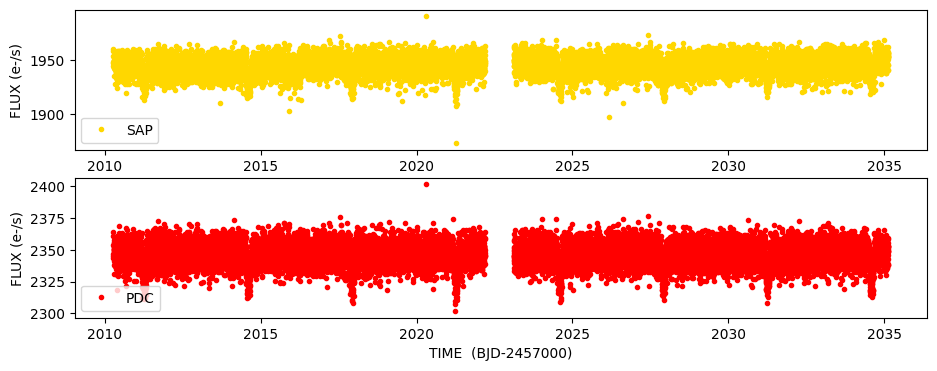

In [148]:
sapflux = lc['SAP_FLUX'] #SAP flux column
pdcflux = lc['PDCSAP_FLUX'] #PDCSAP flux column
time_lc = lc['TIME'] #time column

fig = plt.figure(figsize = (11,4))

fig.add_subplot(211)
plt.plot(time_lc, sapflux,'.', label = 'SAP', color = "gold")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")

fig.add_subplot(212)
plt.plot(time_lc, pdcflux,'.', label = 'PDC', color = "red")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

We notice some intersting things about this data immediately. There are some obvious dips in the light curve that could be our transiting exoplanet but at this step it is hard to see them, let's zoom in on one of the dips in the SAP flux plot. 

(1900.0, 2000.0)

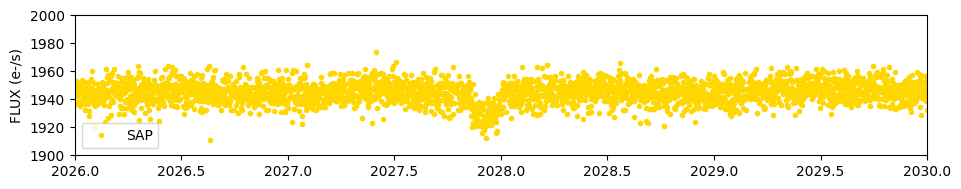

In [156]:
fig = plt.figure(figsize = (11,4))

fig.add_subplot(211)
plt.plot(time_lc, sapflux,'.', label = 'SAP', color = "gold")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlim(2026,2030)
plt.ylim(1900,2000) 

Great, now we can see a clear transit of WASP-153 b ! The next step is to see what this light curve looks like when we calculate it ourselves from the Target Pixel File. 

### Creating a Light Curve from the Target Pixel File

Now, we will use the other FITS file we have downloaded to extract the light curve from the pixels. Aftwards, we can compare these two light curves. 

Let's start by examining the contents of our Target Pixel FITS file. 

In [157]:
fits.info(tp_file)

Filename: ./mastDownload/TESS/tess2020160202036-s0026-0000000157586003-0188-s/tess2020160202036-s0026-0000000157586003-0188-s_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   17909R x 11C   [D, E, J, 121J, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


#### Determining the Optimal Aperture from the PIXELS extension
Each pixel in the aperture extension image is an integer that represents a set of binary flags. The entire set of flags and what they mean can be found in the [TESS Archive Manual](https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual). Of interest to us in this exersize is which pixels belong to the "optimal aperture" used to create this target's light curve.

In [158]:
aperture_image = tp_fits[2].data
aperture = np.bitwise_and(aperture_image, 2) / float(2)
aperture

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Get the Flux and Time for the Optimal Aperture
We can see that there are some values of "1" in our optimal aperture array, these indicate the pixels that we will use to create the target's light curve. Now, to create a time series we need to sum the FLUX values for each of the pixels in the optimal aperture. 

In [159]:
#This is a basic function for getting the aperture photometry
def aperture_phot(image,aperture):
    flux = np.sum(image[aperture==1])
    return flux

In [160]:
#get the data for the PIXELS extension of our fits file
pix = tp_fits[1].data

#Use the map lambda function to sum all the flux in each pixel in our defined aperture
flux = np.array(list (map (lambda x: aperture_phot(x,aperture), pix['FLUX'])))

#get the time from the PIXELS extension of our fits file
time = pix["TIME"]

### Plot the Light Curve


(1900.0, 2000.0)

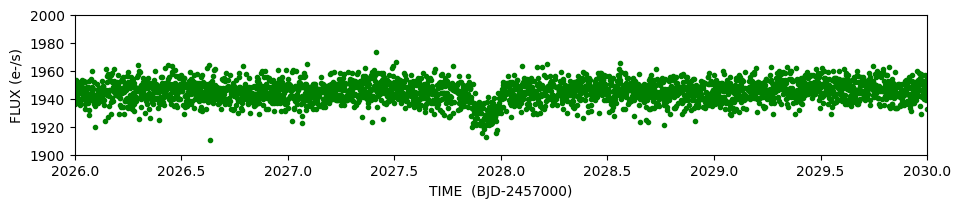

In [161]:
fig = plt.figure(figsize = (11,4))
fig.add_subplot(212)
plt.plot(time, flux,'.', color = "green")
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')
plt.xlim(2026,2030)
plt.ylim(1900,2000)

### Compare Light Curves
Now that we have a SAP_FLUX light curve and and the light curve we calculated with the target pixel files, we can overplot them.

(1900.0, 2000.0)

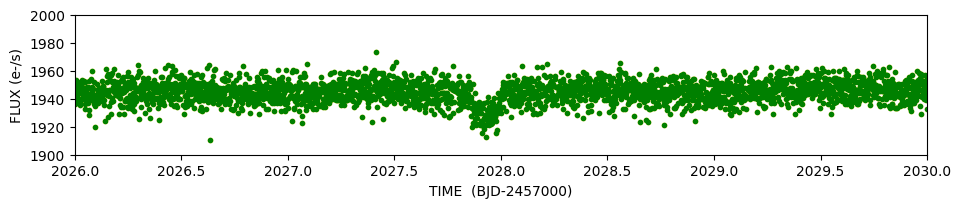

In [163]:
fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(time_lc, sapflux, ".", color = "gold")
plt.plot(time, flux,'.', color = "green")
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')
plt.xlim(2026,2030)
plt.ylim(1900,2000)

Success! The light curve that we calculated from our Target Pixel file overlaps exactly the SAP_FLUX light curve we got from the Light Curve file.

## Create a Light Curve from an FFI
Lastly, we will explore how to get a light curve by cutting out an FFI (Full Frame Image). The process is very similar as the Target Pixel File method we used earlier. Let's start by making sure TESS has an FFI of WASP-153 that we can use. 

In [164]:
TESS_table = Observations.query_criteria(objectname="WASP-153"
                                         , obs_collection="TESS"
                                         , target_name="TESS FFI")

TESS_table

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str14,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str133,str1,str1,str6,bool,float64,str8,str9,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0026-2-4,278.7618655498457,43.20222322326989,image,"Ricker, George",3,59009.77245087,59034.62686916,1425.599348,600.0,1000.0,--,59064.0,N/A,--,26,POLYGON 270.48986200 37.49033900 270.42985300 49.39351200 288.85752200 47.94902600 285.28910500 36.76681600 270.48986200 37.49033900,--,--,PUBLIC,False,nan,27699645,70982257,70982257,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0014-2-3,282.56688498060043,43.725021215245,image,"Ricker, George",3,58682.85618872,58709.68921275,1425.599392,600.0,1000.0,--,58739.3333334,N/A,--,14,POLYGON 279.28066200 35.98200000 270.88665300 45.56181500 286.99842400 51.62389600 293.19108600 40.51599400 279.28066200 35.98200000,--,--,PUBLIC,False,nan,27463640,70511524,70511524,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0040-2-3,270.83871762982267,42.73545628935954,image,"Ricker, George",3,59390.15449739583,59418.355573692126,475.199784,600.0,1000.0,--,59456.0,N/A,--,40,POLYGON 265.739529 35.60932 259.967811 46.241397 277.496353 49.825348 280.190102 38.07897 265.739529 35.60932,--,--,PUBLIC,False,nan,62431375,117202307,117202307,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0054-3-1,280.94236545388816,36.637760365356854,image,"Ricker, George",3,59769.39798581019,59795.626860254626,475.199781,600.0,1000.0,--,59828.0,N/A,--,54,POLYGON 276.812011 29.262522 270.822517 39.641288 286.13531 44.103842 290.035036 32.59231 276.812011 29.262522,--,--,PUBLIC,False,nan,92616902,176483252,176483252,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0053-2-4,280.782887166559,43.451455920183584,image,"Ricker, George",3,59743.49434482639,59768.480714930556,475.199775,600.0,1000.0,--,59786.0,N/A,--,53,POLYGON 272.747793 37.531911 272.105634 49.42548 290.697628 48.44544 287.61407 37.183729 272.747793 37.531911,--,--,PUBLIC,False,nan,87826122,169470001,169470001,0.0


We can see that there are multiple FFI's for Kepler-495 in the TESS database. Great!

### Use Astrocut to get pixel timeseries cutout from TESS FFIs

Now, we have to use the package Astrocut to cut out the pixels in our FFI around our target's coordinates. This will give us an HDUlist. HDUlist objects are the same thing you get back when you download a fits file and then run `astropy.io.fits.open(FITS_file_name)`, which is what we did earlier. We'll retrieve the data from astrocut for our tagret, of size 10x10 pixels, and from the same sector we looked at in the two methods earlier. 

The format of the data from astrocut is exactly the same as a Target Pixel File, so we will perform the same steps as before to plot the light curve. 


In [165]:
# Get the FFI cutout
hdulist = Tesscut.get_cutouts(objectname = "WASP-153"
                              , size = 10
                              , sector=14
                             )

In [166]:
# Look at the file headers
hdulist[0].info()

# Load the first results
hdu1 = hdulist[0]

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  PIXELS        1 BinTableHDU    281   1241R x 12C   [D, E, J, 100J, 100E, 100E, 100E, 100E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        82   (10, 10)   int32   


Now, we will follow the same steps as earlier for using a Target Pixel File to plot a light curve. This will utilize the function we defined earlier `aperture_phot`. However, this time we will be using all the pixels in the cutout instead of finding an Optimal Aperture. To use all the returned pixels, we set our 2D aperture array to be True for all those with a value of 1 in that image. 

In [167]:
# Use all pixels in our aperture
aperture_ffi = hdu1[2].data

# get the data for the PIXELS extension of our fits file
pix_ffi = hdu1[1].data

# Use the map lambda function to sum all the flux in each pixel in our defined aperture
flux_ffi = np.array(list (map (lambda x: aperture_phot(x, aperture_ffi), pix_ffi['FLUX'])))

# Get the time array so we have an x-axis to plot
time_ffi = hdu1[1].data['TIME']

### Plot the Light Curve

As before, we'll create a flux vs. time plot of the data.

Text(0.5, 0, 'TIME  (BJD-2457000)')

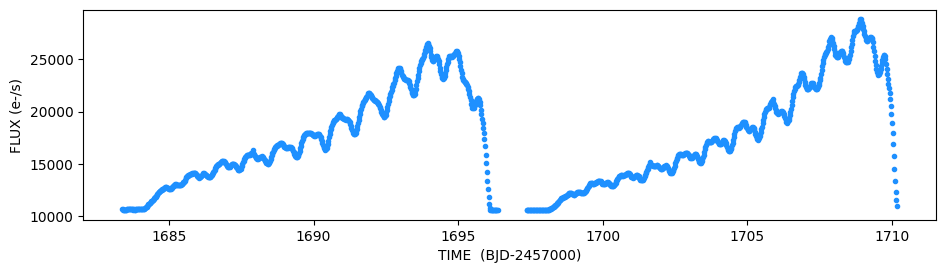

In [168]:
# Create the figure/subplot
fig = plt.figure(figsize = (11,6))
fig.add_subplot(212)

# Add the data and axis labels
plt.plot(time_ffi, flux_ffi,'.', color = "dodgerblue")
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

Wait! This looks very different from our plots before. It turns out that behind the scenes, our TPFs and LCs were benefitting additional calibration and background subtraction. The two spikes we see are effects of TESS's orbit and stray light from the Earth or the moon.

We could do background subtraction ourselves, but that topic is addressed in later Notebooks (e.g. 09). For now, let's just "zoom in" around one level of flux to get a closer look.

(1690.0, 1695.0)

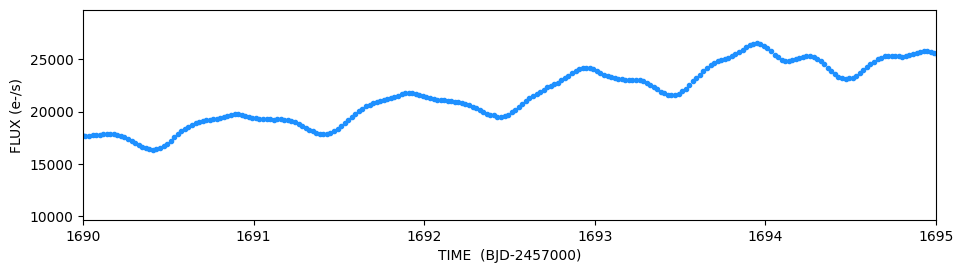

In [170]:
# Create the same plot as before
fig = plt.figure(figsize = (11,6))
fig.add_subplot(212)
plt.plot(time_ffi, flux_ffi,'.', color = "dodgerblue")
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

# Zoom in 
plt.xlim(1690,1695)
# plt.ylim(1700,2000)

Unfortunately, we can't see any real transits here. 

If you look closely, you'll notice two things:

   1. The amplitude of the oscillations increases over time
   2. The period is roughly 1 day

This is actually due to stray light from Earth entering the field of view -- the day-period oscillation is actually Earth itself turning! While this is interesting, it is not what we were after. Luckily, in the next lesson, we will learn how to do more robust data processing to create more accurate light curves and hopefully find a real planet. Stay tuned!

## More application for timeseries data
We call lightcurves "timeseries" data because it is the process of visualizing the light from an object (or system) in the **time domain**, as opposed to the wavelength domain (which would be called a spectrum) or just in the sky (which would be called an image).

As hinted at in the beginning of this lesson, lightcurves can be used to analyse a wide variety of astronomical systems. Including, but not limited to, transient events such as supernovae or gamma ray bursts, periodic variations such as eclipsing binary stars or radio pulsars, and they can be used to detect aperiodic variations too such as blackholes with bright accretion disks. For more information on the many applications of lightcurves in astronomy, check out both the [basic](https://imagine.gsfc.nasa.gov/science/toolbox/timing1.html) and [advanced](https://imagine.gsfc.nasa.gov/science/toolbox/timing2.html) pages on timing analysis from NASA. 

<!-- ## Homework
<!-- Geometry puzzle. Assuming a normal distribution of orbital inclinations, what fraction of planets with radius R$_E$ would we observe fully transiting the disk of their sun-like (R = R☉) host stars?  -->

Choose an exoplanet from the TESS [Target Of Interest (TOI)](https://tev.mit.edu/data/collection/193/) table, perform a TESSCut, and plot a lightcurve from the FFI. Can you identify any dips in the lightcurve that correspond to a transit of this planet? 

## Additional Resources
Can't get enough? Here are some links to more information!

NASA's Exoplanet Exploration page has a [great visualization](https://exoplanets.nasa.gov/exoplanet-catalog/6057/wasp-153-b/) of WASP-153b.

Here is the paper which announced the [discovery of the exoplanet around WASP-153](https://www.aanda.org/articles/aa/full_html/2018/02/aa31735-17/aa31735-17.html). 

Here is a link to the [SIMBAD page](http://simbad.cds.unistra.fr/simbad/sim-id?Ident=WASP-153&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) on WASP-153.

NASA's [Exoplanet Exploration](https://exoplanets.nasa.gov/resources/1040/hot-jupiter/) page on Hot Jupiters. 

NASA's [basic](https://imagine.gsfc.nasa.gov/science/toolbox/timing1.html) and [advanced](https://imagine.gsfc.nasa.gov/science/toolbox/timing2.html) pages on lightcurves and timing analysis.

Here are a few resources on Transit Geometry and Probability:
- NASA's [About Transits](https://www.nasa.gov/kepler/overview/abouttransits) page
- Astrobites article on [Transit Probability](https://astrobites.org/2013/05/23/transit-probabilities-not-as-simple-as-they-seem/)
- [Textbook chapter](https://ethz.ch/content/dam/ethz/special-interest/phys/particle-physics/quanz-group-dam/documents-old-s-and-p/Courses/ExtrasolarPlanetsFS2016/exop2016_chapter3_part2.pdf) on Transits from ETH Zurich

For more info on TESS data products, visit the [Data Product Overview Page](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview).

## Whats next?
You may have noticed that there is some messy signal in our light curves, next week we will learn what a data quality flag is and how to remove data corresponding to bad data quality flags in order to clean up our plots. Additonally, we will start to look into other types of systems that can be identified using the transit method/light curves. 

## Acknowledgements

This notebook includes data collected with the TESS mission, obtained from the MAST data archive at the Space Telescope Science Institute (STScI). Funding for the TESS mission is provided by the NASA Explorer Program. STScI is operated by the Association of Universities for Research in Astronomy, Inc., under NASA contract NAS 5–26555.

Any published work that uses Astroquery should include a citation which can be found at [this link](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION) or the BibTeX entry is available from the package itself with: `astroquery.__citation__`

### Notebook Information:
Author: Emma Lieb

Last Updated: July 2023

<img style=float:right; src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 